In [1]:
import sys
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2) 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

In [4]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CSV.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2021-01-04,31.520000,31.620001,30.709999,30.969999,30.969999,77900
247,2021-01-05,31.000000,32.020000,31.000000,31.809999,31.809999,94900
248,2021-01-06,32.049999,34.000000,32.049999,33.430000,33.430000,157100
249,2021-01-07,34.000000,34.430000,33.660000,33.980000,33.980000,117700
250,2021-01-08,34.110001,34.180000,33.250000,33.630001,33.630001,92400


In [5]:
df['Date']= pd.to_datetime(df['Date'])


In [6]:
df.set_index("Date",inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,31.520000,31.620001,30.709999,30.969999,30.969999,77900
2021-01-05,31.000000,32.020000,31.000000,31.809999,31.809999,94900
2021-01-06,32.049999,34.000000,32.049999,33.430000,33.430000,157100
2021-01-07,34.000000,34.430000,33.660000,33.980000,33.980000,117700
2021-01-08,34.110001,34.180000,33.250000,33.630001,33.630001,92400


In [7]:
# Correlation matrix
df.corr()['Close']

Open         0.992819
High         0.995887
Low          0.997442
Close        1.000000
Adj Close    0.999814
Volume      -0.498830
Name: Close, dtype: float64

In [8]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count       251.000000
mean     137443.027888
std       91980.793980
min       28800.000000
25%       71400.000000
50%      115700.000000
75%      178200.000000
max      653000.000000
Name: Volume, dtype: float64


In [9]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [10]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [11]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [12]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [13]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [14]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(251, 3)
                Close       High  Volume
Date                                    
2021-01-04  30.969999  31.620001   77900
2021-01-05  31.809999  32.020000   94900
2021-01-06  33.430000  34.000000  157100
2021-01-07  33.980000  34.430000  117700
2021-01-08  33.630001  34.180000   92400


In [15]:
# Train Val Test Split
# train_data = series.loc[0:150]

# val_data = series.loc[151:201]
# test_data = series.loc[202:250]
# print(train_data.shape,val_data.shape,test_data.shape)

In [16]:
train_start = dt.date(2020,1,13)
train_end = dt.date(2020,8,18)
train_data = series.loc[train_start:train_end]


val_start = dt.date(2020,8,19)
val_end = dt.date(2020,10,28)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020,10,28)
test_end = dt.date(2021,1,8)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(152, 3) (50, 3) (50, 3)


In [17]:
# Train Val Test Split

# train_start = '2020-01-13'
# train_end = '2020-08-18'
# mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
# train_data = series.loc[mask]

# # train_start = dt.date(2020,01,13)
# # train_end = dt.date(2020,08,18)
# # train_data = series.loc[train_start:train_end]

# val_start = '2020-08-19'
# val_end = '2020-10-28'
# mask1 = (df['Date'] > val_start) & (df['Date'] <= val_end)
# val_data = series.loc[mask1]

# test_start = '2020-10-29'
# test_end = '2020-01-08'
# mask2 = (df['Date'] > test_start) & (df['Date'] <= test_end)
# test_data = series.loc[mask2]

# print(train_data.shape,val_data.shape,test_data.shape)

In [18]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(152, 3) (50, 3) (50, 3)


In [19]:
timesteps = 5
hl = [15,10]
lr = 1e-3
batch_size = 10
num_epochs = 700

Epoch 00251: early stopping


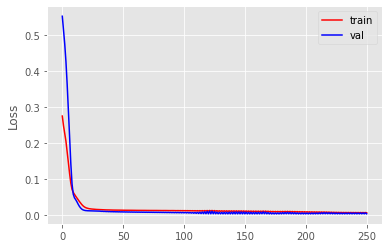

In [20]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.00695153126410855
RMSE = 0.08337584340867893
R-Squared Score = 0.6752126174784308


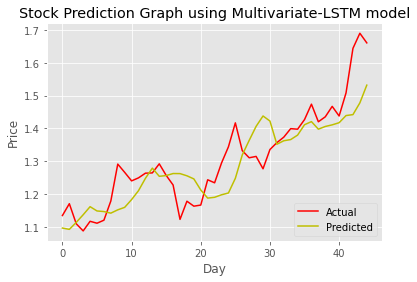

In [21]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)